In [1]:
from pathlib import Path
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np

os.environ["WANDB_SILENT"] = "true"

from pathlib import Path
import numpy as np
import pandas as pd

In [2]:
data_path = "../data/"
"""
Build `X_train_mean, X_val_mean, X_train, X_val, y_train, y_val`
TODO: add other aggregation that mean (e.g. max) ? Use a dict ?
"""

# put your own path to the data root directory (see example in `Data architecture` section)
data_dir = Path(data_path)

# load the training and testing data sets
train_features_dir = data_dir / "train_input" / "moco_features"
test_features_dir = data_dir / "test_input" / "moco_features"
df_train_val = pd.read_csv(data_dir / "supplementary_data" / "train_metadata.csv")
df_test = pd.read_csv(data_dir / "supplementary_data" / "test_metadata.csv")


# concatenate y_train_val and df_train_val
y_train_val = pd.read_csv(data_dir / "train_output.csv")
df_train_val = df_train_val.merge(y_train_val, on="Sample ID")


In [3]:
center_list = ['C_1', 'C_2', 'C_5']
X_dict = {}
y_dict = {}

for center_curr in center_list:
    X_train = []
    y_train = []
    centers_train = []

    for sample, label, center, patient in df_train_val[
        ["Sample ID", "Target", "Center ID", "Patient ID"]
    ].values:
        if center == center_curr:
            # load the coordinates and features (1000, 3+2048)
            _features = np.load(train_features_dir / sample)
            # get coordinates (zoom level, tile x-coord on the slide, tile y-coord on the slide)
            # and the MoCo V2 features
            coordinates, features = _features[:, :3], _features[:, 3:]  # Ks
            X_train.append(features)
            y_train.append(label)
            centers_train.append(center)

    # convert to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    centers_train = np.array(centers_train)

    X_dict[center_curr] = X_train
    y_dict[center_curr] = y_train

In [90]:
def hausdorf_matrix_single(bags):
    """Hausdorf distance for a single set of bags."""
    n = bags.shape[0]
    hausdorf = np.zeros((n, n, 3))
    for i in tqdm(range(n)):
        for j in range(i, n):
            dist = np.einsum('ij,ij->i', bags[i], bags[i])[:,None] + np.einsum('ij,ij->i', bags[j], bags[j]) - 2 * np.dot(bags[i], bags[j].T)
            
            min1 = np.min(dist, axis=-1)
            min2 = np.min(dist, axis=0)

            # Vanilla Hausdorf
            dist1 = np.max(min1)
            dist2 = np.max(min2)
            H_max = max(dist1, dist2)

            # Mean Hausdorf
            H_mean = (np.sum(min1) + np.sum(min2)) / (np.size(min1) + np.size(min2)) 

            # Min Hausdorf
            H_min = np.min(min1)

            hausdorf[i, j] = np.array([H_max, H_mean, H_min])
            hausdorf[j, i] = np.array([H_max, H_mean, H_min])
    return hausdorf

def hausdorf_matrix_dual(bags_pred, bags_train):
    """Hausdorf distance between two set of bags."""
    n = bags_pred.shape[0]
    m = bags_train.shape[0]
    hausdorf = np.zeros((n, m, 3))
    for i in tqdm(range(n)):
        for j in range(m):
            dist = np.einsum('ij,ij->i', bags_pred[i], bags_pred[i])[:,None] + np.einsum('ij,ij->i', bags_train[j], bags_train[j]) - 2 * np.dot(bags_pred[i], bags_train[j].T)
            
            min1 = np.min(dist, axis=-1)
            min2 = np.min(dist, axis=0)

            # Vanilla Hausdorf
            dist1 = np.max(min1)
            dist2 = np.max(min2)
            H_max = max(dist1, dist2)

            # Mean Hausdorf
            H_mean = (np.sum(min1) + np.sum(min2)) / (np.size(min1) + np.size(min2)) 

            # Min Hausdorf
            H_min = np.min(min1)

            hausdorf[i, j] = np.array([H_max, H_mean, H_min])
    return hausdorf

In [87]:
for center in center_list:
    X = X_dict[center]
    matrix = hausdorf_matrix_single(X)
    np.save(f'hausdorf_{center}.npy', matrix)

100%|██████████| 114/114 [09:20<00:00,  4.92s/it]


In [92]:
center1 = 'C_1'
for center2 in center_list:
    if center1 != center2:
        X1 = X_dict[center1]
        X2 = X_dict[center2]
        matrix = hausdorf_matrix_dual(X1, X2)
        np.save(f'hausdorf_{center1}_{center2}.npy', matrix)

center1 = 'C_2'
center2 = 'C_5'
X1 = X_dict[center1]
X2 = X_dict[center2]
matrix = hausdorf_matrix_dual(X1, X2)
np.save(f'hausdorf_{center1}_{center2}.npy', matrix)

100%|██████████| 92/92 [14:47<00:00,  9.64s/it]


In [170]:
def get_matrices(center1, center2, center_test, y_dict):

    y1 = y_dict[center1]
    y2 = y_dict[center2]
    y_train = np.concatenate((y1, y2))
    y_test = y_dict[center_test]
    
    n1 = y1.size
    n2 = y2.size
    n_train = n1 + n2
    n_test = y_test.size

    distances_train = np.zeros((n_train, n_train, 3))
    distances_train[:n1, :n1] = np.load(f'hausdorf_{center1}.npy')
    distances_train[n1:, n1:] = np.load(f'hausdorf_{center2}.npy')
    distances_train[:n1, n1:] = np.load(f'hausdorf_{center1}_{center2}.npy')
    distances_train[n1:, :n1] = np.moveaxis(np.load(f'hausdorf_{center1}_{center2}.npy'), 0, 1)
    distances_train[distances_train < 0] = 0

    distances_pred = np.zeros((n_train, n_test, 3))
    if center1 < center_test:
        distances_pred[:n1] = np.load(f'hausdorf_{center1}_{center_test}.npy')
    else:
        distances_pred[:n1] = np.moveaxis(np.load(f'hausdorf_{center_test}_{center1}.npy'), 0, 1)
    
    if center2 < center_test:
        distances_pred[n1:] = np.load(f'hausdorf_{center2}_{center_test}.npy')
    else:
        distances_pred[n1:] = np.moveaxis(np.load(f'hausdorf_{center_test}_{center2}.npy'), 0, 1)
    distances_pred[distances_pred < 0] = 0

    return distances_train, y_train, distances_pred, y_test

In [175]:
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

def plot_roc(distances_train, y_train, distances_pred, y_test):
    n_neighbors = np.arange(1, 100)
    fig, axs = plt.subplots(3)

    for hausdorf_type in range(3):
        roc_auc = np.zeros_like(n_neighbors, dtype=float)
        roc_auc_weight = np.zeros_like(n_neighbors, dtype=float)

        for n_neighbor in n_neighbors: 
            classifier = KNeighborsClassifier(n_neighbors=n_neighbor, metric="precomputed")
            classifier.fit(distances_train[:,:,hausdorf_type], y_train)
            y_pred = classifier.predict_proba(distances_pred[:,:,hausdorf_type].T)
            roc_auc[n_neighbor - 1] = roc_auc_score(y_test, y_pred[:, 1])

            classifier = KNeighborsClassifier(n_neighbors=n_neighbor, metric="precomputed", weights="distance")
            classifier.fit(distances_train[:,:,hausdorf_type], y_train)
            y_pred = classifier.predict_proba(distances_pred[:,:,hausdorf_type].T)
            roc_auc_weight[n_neighbor - 1] = roc_auc_score(y_test, y_pred[:, 1])

        axs[hausdorf_type].plot(roc_auc, label='number')
        axs[hausdorf_type].plot(roc_auc_weight, label='weight')
        axs[hausdorf_type].legend(loc='best')
    plt.show()

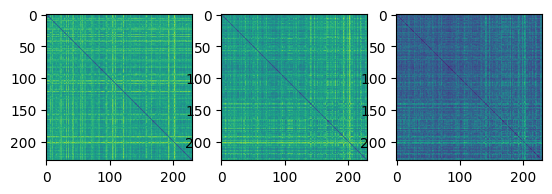

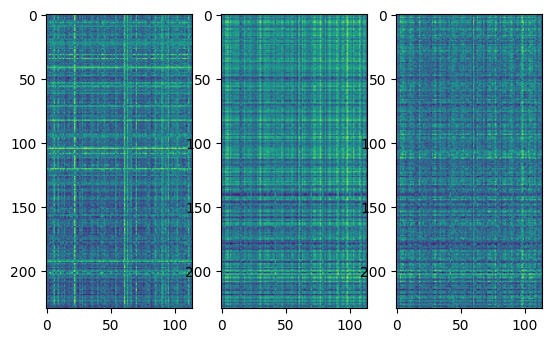

In [176]:
list_cross_val_train = [['C_1', 'C_2'], ['C_1', 'C_5'], ['C_2', 'C_5']]
list_cross_val_test = ['C_5', 'C_2', 'C_1']

center1, center2 = list_cross_val_train[0]
center_test = list_cross_val_test[0]

distances_train, y_train, distances_pred, y_test = get_matrices(center1, center2, center_test, y_dict)

plt.subplot(131)
plt.imshow(distances_train[:,:, 0] / distances_train[:,:, 0].max())
plt.subplot(132)
plt.imshow(distances_train[:,:, 1] / distances_train[:,:, 1].max())
plt.subplot(133)
plt.imshow(distances_train[:,:, 2] / distances_train[:,:, 2].max())
plt.show()

plt.subplot(131)
plt.imshow(distances_pred[:,:, 0] / distances_train[:,:, 0].max())
plt.subplot(132)
plt.imshow(distances_pred[:,:, 1] / distances_train[:,:, 1].max())
plt.subplot(133)
plt.imshow(distances_pred[:,:, 2] / distances_train[:,:, 2].max())
plt.show()

C_1, C_2 as train set and C_5 as test set


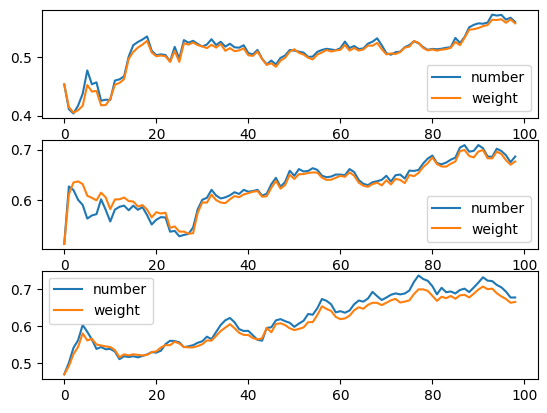

C_1, C_5 as train set and C_2 as test set


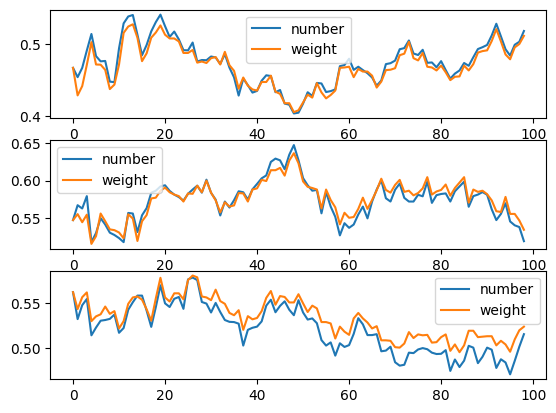

C_2, C_5 as train set and C_1 as test set


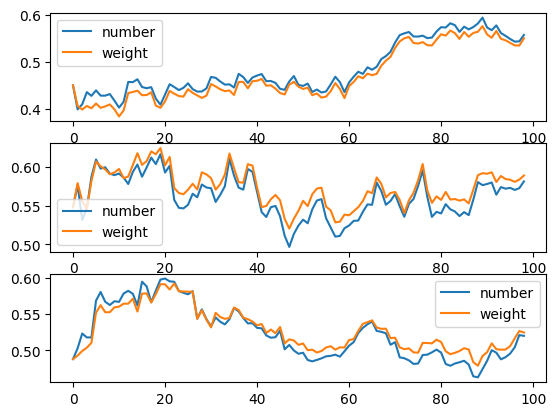

In [177]:
for i in range(len(list_cross_val_train)):
    center1, center2 = list_cross_val_train[i]
    center_test = list_cross_val_test[i]
    print(f'{center1}, {center2} as train set and {center_test} as test set')
    
    distances_train, y_train, distances_pred, y_test = get_matrices(center1, center2, center_test, y_dict)
    plot_roc(distances_train, y_train, distances_pred, y_test)